In [1]:
import sys
import torch
import numpy as np
import pandas as pd
from pathlib import Path

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

models_path = "/home/../multiTS/NFT"
if models_path not in sys.path: sys.path.append(models_path)

from models.NFT.NFT import NFT
from models.training_functions import evaluate_model

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [2]:
plot = True

steps = [(7, 1), (15, 1), (15, 7), (30, 1), (30, 7), (30, 15)]
n_vars = [i for i in range(1, 9)]

stacks = [('trend', 'trend')]
thetas = [(1, 1), (2,2), (3,3), (4,4)]
blocks = [1,2,3]
epochs = [15]



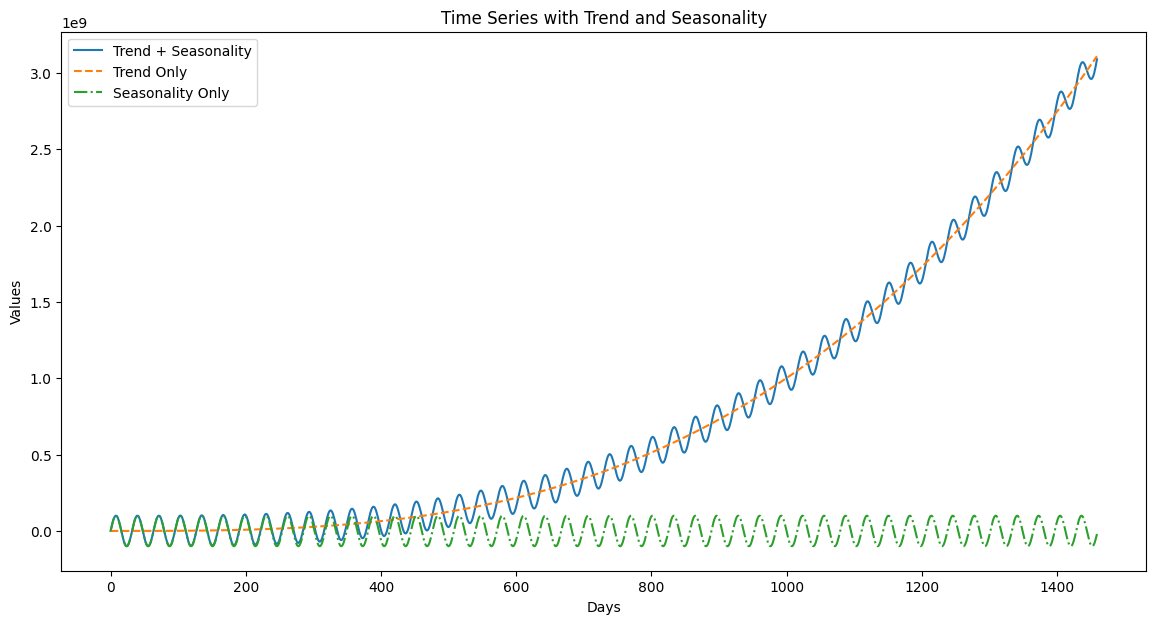

In [21]:
import numpy as np
import matplotlib.pyplot as plt

# Time setup
n_points = 365 * 4
time = np.arange(n_points)
years = time / 365  # Convert time to years for seasonal components

# Trend component using polynomial1
trend = 1 * time**3 + 2 * time**2 + 3 * time + 4

# Seasonal component with yearly seasonality
seasonal_frequency = 23 * np.pi / 365  # One cycle per year
seasonal_amplitude = 100000000  # Amplitude of the seasonal component
seasonality = seasonal_amplitude * np.sin(seasonal_frequency * time)

# Combine trend and seasonality to create the time series
time_series = trend + seasonality

# Plot the time series
plt.figure(figsize=(14, 7))
plt.plot(time, time_series, label='Trend + Seasonality')
plt.plot(time, trend, label='Trend Only', linestyle='--')
plt.plot(time, seasonality, label='Seasonality Only', linestyle='-.')
plt.xlabel('Days')
plt.ylabel('Values')
plt.title('Time Series with Trend and Seasonality')
plt.legend()
plt.show()


In [76]:
def get_data(lookback, horizon, n_vars, plot=True, mod=False):
    def create_datasets(data, lookback, horizon):
        X, y = [], []
        for i in range(len(data) - lookback - horizon + 1):
            X.append(data[i:(i + lookback)])
            y.append(data[(i + lookback):(i + lookback + horizon)])
        return np.array(X), np.array(y)

    def split_data(X, y):
        n_samples = X.shape[0]
        train_samples = int(n_samples * 0.7)
        val_samples = int(n_samples * 0.15)

        train_X = torch.tensor(X[:train_samples], dtype=torch.float32)
        train_y = torch.tensor(y[:train_samples], dtype=torch.float32)

        val_X = torch.tensor(X[train_samples:train_samples + val_samples], dtype=torch.float32)
        val_y = torch.tensor(y[train_samples:train_samples + val_samples], dtype=torch.float32)

        test_X = torch.tensor(X[train_samples + val_samples:], dtype=torch.float32)
        test_y = torch.tensor(y[train_samples + val_samples:], dtype=torch.float32)
        
        return train_X.to(device), train_y.to(device), val_X.to(device), val_y.to(device), test_X.to(device), test_y.to(device)

    n_points = 365 * 4 
    time = np.arange(n_points)


    polynomial1 = 1 * time**3 + 2 * time**2 + 3 * time + 4

    polynomial2 = 0 * time**3 + 10 * time**2 + 5 * time + 0

    polynomial3 = -5 * time**3 - 15 * time**2 + 5 * time + 3

    polynomial4 = -0.7 * time**3 + 6 * time**2 -0.7 * time - 7

    polynomial5 = 3 * time**3 - 27 * time**2 - 0.5 * time + 2.1

    polynomial6 = 4 * time**3 + 2 * time**2 + 1 * time + 1

    polynomial7 = -4 * time**3 - 0.1 * time**2 - 7 * time + 25

    polynomial8 = 0.4 * time**3 - 6 * time**2 - 0.1 * time - 6
    
    if mod:
        polynomial1 = polynomial1 + 100000000 * np.sin(3 * time)
        polynomial2 = polynomial2 + 50000000 * np.sin(1 * time)
        polynomial3 = polynomial3 + 300000000 * np.sin(3 * time)
        polynomial4 = polynomial4 + 100000000 * np.sin(3 * time)
        polynomial5 = polynomial5 + 10000000 * np.sin(4 * time)
        polynomial6 = polynomial6 + 900000000 * np.sin(0.02 * time)
        polynomial7 = polynomial7 + 50000000 * np.sin(1 * time)
        polynomial8 = polynomial8 + 50000000 * np.sin(0.7 * time)

    p = (polynomial1, polynomial2, polynomial3, polynomial4, polynomial5, polynomial6, polynomial7, polynomial8)


    multivariate_time_series = np.column_stack(p[:n_vars])
    
    if plot:
        plt.figure(figsize=(12, n_vars))
        for i in range(n_vars): plt.plot(time, p[i], label=f'Polynomial {i}')
        plt.xlabel('Time')
        plt.ylabel('Value')
        plt.title('Polynomials Over Time')
        plt.legend()
        plt.show()

    print(f"multivariate_time_series.shape={multivariate_time_series.shape}")

    X, y = create_datasets(multivariate_time_series, lookback, horizon)

    train_X, train_y, val_X, val_y, test_X, test_y = split_data(X, y)

    print(train_X.shape, train_y.shape, val_X.shape, val_y.shape, test_X.shape, test_y.shape)
    
    return train_X, train_y, val_X, val_y, test_X, test_y

def to_numpy(data):
    """Converts input data to a NumPy array, handling both PyTorch tensors and NumPy arrays."""
    if isinstance(data, torch.Tensor):
        # Move tensor to CPU if it's on a CUDA device, then convert to NumPy
        return data.cpu().numpy() if data.is_cuda else data.numpy()
    elif isinstance(data, np.ndarray):
        # If it's already a NumPy array, just return it
        return data
    else:
        # If it's a scalar (e.g., Python int or float), convert to a NumPy array
        return np.array(data)

def train_model_and_save_evals(lookback, horizon, n_vars, stack_types, thetas_dim, nb_blocks_per_stack, epochs, train_X, train_y, val_X, val_y, test_X, test_y, is_poly):
    model = NFT(
        forecast_length=horizon,
        backcast_length=lookback,
        stack_types=stack_types,
        thetas_dim=thetas_dim,
        n_vars=n_vars,
        nb_blocks_per_stack=nb_blocks_per_stack,
        num_channels_for_tcn=[2, 2],
        is_poly=is_poly
        ).to(device)

    model.compile(loss='mse', optimizer='adam')

    model.fit(
        x_train=train_X, 
        y_train=train_y, 
        validation_data=(val_X, val_y), 
        epochs=epochs,
        batch_size=32, 
        plot_epoch=100
        )

    _, _, _, _, test_mse, _, test_smape, _, _, _, test_mase = evaluate_model(model, train_X, train_y, val_X, val_y, test_X, test_y)
    
    file_path = '/home/../multiTS/NFT/results/evaluate_trend_syntatic_data.xlsx'

    if Path(file_path).is_file(): df = pd.read_excel(file_path)
    else: df = pd.DataFrame(columns=["Lookback", "Horizon", "Vars", "Epochs", "Stacks", 
                                     "Dagree", "Blocks", "Is Poly", 
                                   "test_mse", "test_smape", "test_mase"])

    new_row = {"Lookback": lookback, "Horizon": horizon, "Vars": n_vars,
               "Epochs": epochs,  "Stacks": stack_types, 
               "Dagree":thetas_dim, "Blocks": nb_blocks_per_stack, 
               "Is Poly":is_poly, "test_mse": to_numpy(test_mse), 
               "test_smape": to_numpy(test_smape), "test_mase": to_numpy(test_mase)}
    
    df = pd.concat([df, pd.DataFrame([new_row])], ignore_index=True)

    df.to_excel(file_path, index=False)


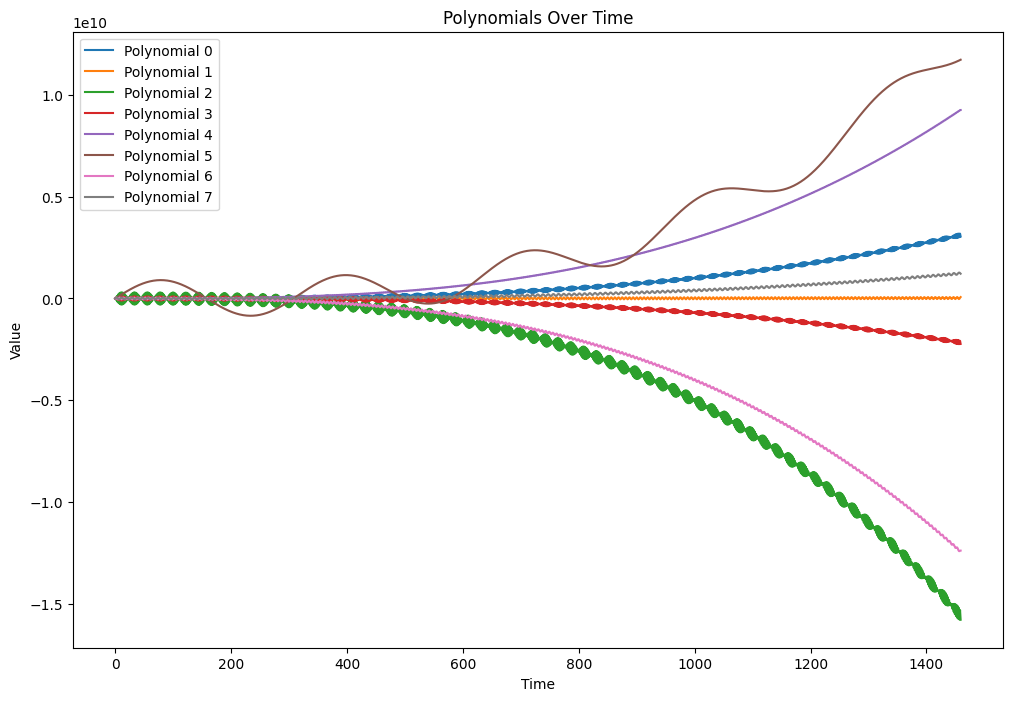

multivariate_time_series.shape=(1460, 8)
torch.Size([1017, 7, 8]) torch.Size([1017, 1, 8]) torch.Size([217, 7, 8]) torch.Size([217, 1, 8]) torch.Size([219, 7, 8]) torch.Size([219, 1, 8])


(tensor([[[ 4.0000e+00,  0.0000e+00,  3.0000e+00,  ...,  1.0000e+00,
            2.5000e+01, -6.0000e+00],
          [ 1.4112e+07,  4.2074e+07,  4.2336e+07,  ...,  1.7999e+07,
            4.2074e+07,  3.2211e+07],
          [-2.7942e+07,  4.5465e+07, -8.3825e+07,  ...,  3.5990e+07,
            4.5465e+07,  4.9272e+07],
          ...,
          [-5.3657e+07, -3.7840e+07, -1.6097e+08,  ...,  7.1924e+07,
           -3.7840e+07,  1.6749e+07],
          [ 6.5029e+07, -4.7946e+07,  1.9509e+08,  ...,  8.9851e+07,
           -4.7947e+07, -1.7539e+07],
          [-7.5098e+07, -1.3970e+07, -2.2530e+08,  ...,  1.0774e+08,
           -1.3972e+07, -4.3579e+07]],
 
         [[ 1.4112e+07,  4.2074e+07,  4.2336e+07,  ...,  1.7999e+07,
            4.2074e+07,  3.2211e+07],
          [-2.7942e+07,  4.5465e+07, -8.3825e+07,  ...,  3.5990e+07,
            4.5465e+07,  4.9272e+07],
          [ 4.1212e+07,  7.0561e+06,  1.2364e+08,  ...,  5.3968e+07,
            7.0559e+06,  4.3160e+07],
          ...,
    

In [77]:
get_data(7, 1, 8, plot, mod=True)

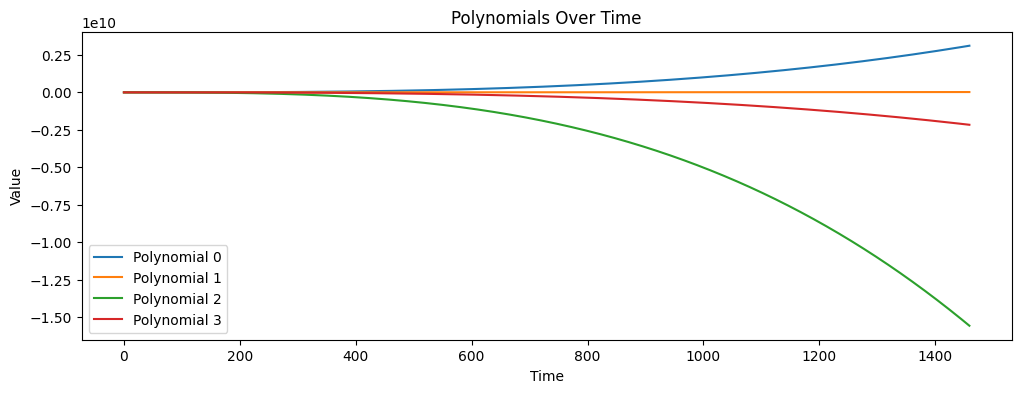

multivariate_time_series.shape=(1460, 4)
torch.Size([1017, 7, 4]) torch.Size([1017, 1, 4]) torch.Size([217, 7, 4]) torch.Size([217, 1, 4]) torch.Size([219, 7, 4]) torch.Size([219, 1, 4])


(tensor([[[ 4.0000e+00,  0.0000e+00,  3.0000e+00, -7.0000e+00],
          [ 1.0000e+01,  1.5000e+01, -1.2000e+01, -2.4000e+00],
          [ 2.6000e+01,  5.0000e+01, -8.7000e+01,  1.0000e+01],
          ...,
          [ 1.1200e+02,  1.8000e+02, -5.3700e+02,  4.1400e+01],
          [ 1.9400e+02,  2.7500e+02, -9.7200e+02,  5.2000e+01],
          [ 3.1000e+02,  3.9000e+02, -1.5870e+03,  5.3600e+01]],
 
         [[ 1.0000e+01,  1.5000e+01, -1.2000e+01, -2.4000e+00],
          [ 2.6000e+01,  5.0000e+01, -8.7000e+01,  1.0000e+01],
          [ 5.8000e+01,  1.0500e+02, -2.5200e+02,  2.6000e+01],
          ...,
          [ 1.9400e+02,  2.7500e+02, -9.7200e+02,  5.2000e+01],
          [ 3.1000e+02,  3.9000e+02, -1.5870e+03,  5.3600e+01],
          [ 4.6600e+02,  5.2500e+02, -2.4120e+03,  4.2000e+01]],
 
         [[ 2.6000e+01,  5.0000e+01, -8.7000e+01,  1.0000e+01],
          [ 5.8000e+01,  1.0500e+02, -2.5200e+02,  2.6000e+01],
          [ 1.1200e+02,  1.8000e+02, -5.3700e+02,  4.1400e+01],
    

In [23]:
get_data(7, 1, 4, plot)

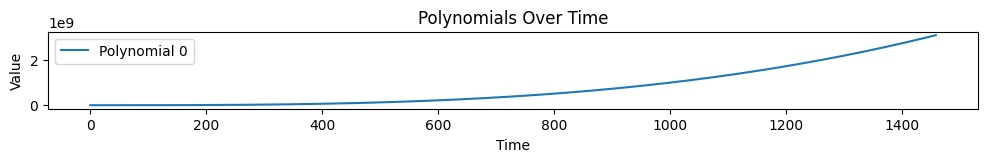

multivariate_time_series.shape=(1460, 1)
torch.Size([1017, 7, 1]) torch.Size([1017, 1, 1]) torch.Size([217, 7, 1]) torch.Size([217, 1, 1]) torch.Size([219, 7, 1]) torch.Size([219, 1, 1])
| NFT
| --  Stack Trend (#0) (share_weights_in_stack=False)
     | -- TrendBlock(units=256, thetas_dim=1, backcast_length=7, forecast_length=1, share_thetas=True) at @140531089572288
| --  Stack Trend (#1) (share_weights_in_stack=False)
     | -- TrendBlock(units=256, thetas_dim=1, backcast_length=7, forecast_length=1, share_thetas=True) at @140531089574784
Epoch 1, Average loss per data point: 1.0565411529540886e+17
Epoch 01/15
32/32 [==============================] - 0s 4ms/step - loss: 105654115295408864.0000 - val_loss: 860477868616974336.0000
Epoch 2, Average loss per data point: 3.2105013955087296e+16
Epoch 02/15
32/32 [==============================] - 0s 4ms/step - loss: 32105013955087296.0000 - val_loss: 198530259052658688.0000
Epoch 3, Average loss per data point: 3475446705370781.5
Epoch 03/

KeyboardInterrupt: 

In [10]:
for s in steps:
    lookback, horizon = s
    for v in [n_vars]:
        train_X, train_y, val_X, val_y, test_X, test_y =  get_data(lookback, horizon, v, plot, mod=True)
        for stack_types in stacks:
            for thetas_dim in thetas:
                for nb_blocks_per_stack in blocks:
                    for epoch in epochs:
                        train_model_and_save_evals(lookback, horizon, v, stack_types, thetas_dim, nb_blocks_per_stack, epoch, train_X, train_y, val_X, val_y, test_X, test_y, is_poly=True)
                        train_model_and_save_evals(lookback, horizon, v, stack_types, thetas_dim, nb_blocks_per_stack, epoch, train_X, train_y, val_X, val_y, test_X, test_y, is_poly=False)